<a href="https://colab.research.google.com/github/hectorcamachoz/Proyecto_2_Inteligenci_Artificial/blob/main/P_P2_594557.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2. Inteligencia Artificial

En este proyecto se utilizara la base de datos proporcionada por Kaggle especificamente de la competencia "Spaceship Titanic". El objetivo de este proyecto es realizar algunos de los multiples modelos vistos en clase, como LDA, QDA, Regresion Logistica, Árboles de decisión, bagging, random forests, boosting, y seleccionar cual es el mejor el resultado que se obtenga se mandara a la competencia de Kaggle. Nuestra variable de salida sera la variable Transported que tiene como valores True o False.


La descripcion de cada variable se encuentra en el archivo: 'descripcion_vars_kaggle.txt'


**1.** Primero se importara la base de datos train.csv, y test.csv. Se juntaran ambas bases de datos para facilitar el proceso de analisis.


In [361]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df = pd.concat([df_train, df_test])
df.head()
df.info()

print('\nHuecos: ')
print(df.isnull().sum())

print('\nBalanceo de Clases en Train.csv:\n',df_train['Transported'].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB

Huecos: 
PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296


Se puede observar que muchas variables son de tipo object, por lo tanto para utilizar regresion logistica, es necesario convertir estas variables a variables dummy.

Primero se eliminaran las variables PassengerId y Name, ya que esas no nos serviran para el entrenamiento del modelo.

In [362]:
df = df.drop(['PassengerId', 'Name'], axis=1)

En la tabla de huecos en el primer apartado, se puede observar que existen multiples huecos en las variables Age, RoomService, CryoSleep, FoodCourt, ShoppingMall, Spa, VRDeck, por lo tanto, los huecos en esas variables se sustituiran por 0, exceptuando la de Age, esa se sustituira por otro valor mas adelante.

In [363]:
df[['RoomService','VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService','VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
print('Tabla de Huecos actualizada: ')
df.isnull().sum().sort_values(ascending=False)

Tabla de Huecos actualizada: 


,0
Transported,4277
Cabin,299
HomePlanet,288
Destination,274
Age,270
CryoSleep,0
RoomService,0
VIP,0
FoodCourt,0
ShoppingMall,0


Se puede observar en la tabla que ya no existen huecos en las variables mencionadas anteriormente. Sin embargo, todavia nos quedan huecos que llenar, eso se resolvera mas adelante.



La variable Cabin, esta compuesta por tres datos, Deck/Cabin number/Side. Para facilitar esta variable se dividira en tres columnas. Este codigo es una combinacion de algunos competidores uno llamado Gusthema y otro llamado Eunice.

Una vez divida la variable, se imputaran valores de la moda en variables categircas (Cabin_num, Deck, Side, Homeplanet, Destination).

Y en variables numericas los valores nulos se sutituiran por la mediana (Age).

In [364]:

df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df = df.drop(['Cabin'], axis = 1)
df[['Cabin_num']] = df[['Cabin_num']].fillna(df['Cabin_num'].mode().iloc[0])
df[['Deck']] = df[['Deck']].fillna(df['Deck'].mode().iloc[0])
df[['Side']] = df[['Side']].fillna(df['Side'].mode().iloc[0])
df['Age'] = df['Age'].fillna(df['Age'].median())

df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode().iloc[0])


df.head(5)

df.isnull().sum().sort_values(ascending=False)

,0
Transported,4277
HomePlanet,0
Destination,0
Age,0
VIP,0
CryoSleep,0
RoomService,0
FoodCourt,0
Spa,0
ShoppingMall,0


Por ultimo solo nos quedan los huecos de la variable Transported, que esos pertenecen a la base de datos de test.csv, ya que esa base de datos no cuenta con esa variable.

Ya que se utilizaran multiples modelos, es necesario convertir las variables Catergoricas en variables binarias, esto se hara con la funcion get_dummies. Por lo pronto, solo se modificaran las variables HomePlanet, Destination, Side, Deck.

In [365]:
df = pd.get_dummies(df,columns= ['HomePlanet', 'Destination','Side'], drop_first = False)
df = pd.get_dummies(df, columns = ['Deck'], drop_first = False)
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_num,...,Side_P,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,...,True,False,False,True,False,False,False,False,False,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,...,False,True,False,False,False,False,False,True,False,False
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,...,False,True,True,False,False,False,False,False,False,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,...,False,True,True,False,False,False,False,False,False,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,...,False,True,False,False,False,False,False,True,False,False


Para evitar tener muchas columnas, se sumaran los gastos de cada pasajero, estos se pondran en una columna llamada **Expenses**, y se eliminaran las columnas de las variables sumadas.

In [366]:
df['Expenses'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
df = df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis = 1)
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,False,39.0,False,False,0,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,0.0
1,False,24.0,False,True,0,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,736.0
2,False,58.0,True,False,0,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,10383.0
3,False,33.0,False,False,0,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,5176.0
4,False,16.0,False,True,1,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,1091.0


Por ultimo es necesario que las variables booleanas sean convertidas a variables binarias. Por lo tanto, se sustituira el valor False por un 0, y el True por un 1.

In [367]:

df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)
df['HomePlanet_Europa'] = df['HomePlanet_Europa'].astype(int)
df['HomePlanet_Mars'] = df['HomePlanet_Mars'].astype(int)
df['HomePlanet_Earth'] = df['HomePlanet_Earth'].astype(int)
df['Destination_TRAPPIST-1e'] = df['Destination_TRAPPIST-1e'].astype(int)
df['Destination_PSO J318.5-22'] = df['Destination_PSO J318.5-22'].astype(int)
df['Destination_55 Cancri e'] = df['Destination_55 Cancri e'].astype(int)
df['Side_S'] = df['Side_S'].astype(int)
df['Side_P'] = df['Side_P'].astype(int)
df['Deck_F'] = df['Deck_F'].astype(int)
df['Deck_G'] = df['Deck_G'].astype(int)
df['Deck_E'] = df['Deck_E'].astype(int)
df['Deck_B'] = df['Deck_B'].astype(int)
df['Deck_D'] = df['Deck_D'].astype(int)
df['Deck_C'] = df['Deck_C'].astype(int)
df['Deck_A'] = df['Deck_A'].astype(int)
df['Deck_T'] = df['Deck_T'].astype(int)
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,0,39.0,0,False,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0
1,0,24.0,0,True,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,736.0
2,0,58.0,1,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,10383.0
3,0,33.0,0,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,5176.0
4,0,16.0,0,True,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1091.0


Se pueden observar todas las variables previamente categoricas, o booleanas, convertidas a valores binarios, con la excepcion de la variable Transported, debido a que esa es nuestra variable de salida, y la base de datos test.csv no cuenta con esa variable, no se le hara nada, hasta que se separen las bases de datos.

In [368]:
print(df.isnull().sum())

CryoSleep                       0
Age                             0
VIP                             0
Transported                  4277
Cabin_num                       0
HomePlanet_Earth                0
HomePlanet_Europa               0
HomePlanet_Mars                 0
Destination_55 Cancri e         0
Destination_PSO J318.5-22       0
Destination_TRAPPIST-1e         0
Side_P                          0
Side_S                          0
Deck_A                          0
Deck_B                          0
Deck_C                          0
Deck_D                          0
Deck_E                          0
Deck_F                          0
Deck_G                          0
Deck_T                          0
Expenses                        0
dtype: int64


Para revisar una vez mas se desplego una tabla de huecos en las variables, y como se habia observado anteriormente solo existen los huecos de la respectiva base de datos test.csv

Por ultimo escalaremos las variables Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, para tenerlas en valores mas pequeños y que sea mas 'facil' para nuestros modelo tener mejores resultados.

In [369]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['Age','Expenses']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,CryoSleep,Age,VIP,Transported,Cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Expenses
0,0,0.720932,0,False,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.510541
1,0,-0.332557,0,True,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.248363
2,0,2.055350,1,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,3.188082
3,0,0.299536,0,False,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1.333249
4,0,-0.894417,0,True,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.121906


Por ultimo, se volveran a separar las bases de datos en train y test. La variable Transported que esta en la base de datos de train sera convertida a un valor binario. Tambien se creara una particion dentro de la base de datos train para poder analizar cada modelo. 80% datos de entrenamiento - 20% datos de prueba

In [370]:
df_train_processed = df.iloc[:len(df_train)]
df_test_processed = df.iloc[len(df_train):]

df_train_processed['Transported'] = df_train_processed['Transported'].astype(int)
df_test_processed = df_test_processed.drop(['Transported'], axis = 1)
df_test_processed['PassengerId'] = df_test['PassengerId']

print('Base de datos Train: ')
print('\n',df_train_processed.head())

print('\nBase de datos Test: ')
print('\n',df_test_processed.head())

#df_test_processed, se usara para el test final, para asi evitar a toda costa una fuga de datos.


x = df_train_processed.drop(['Transported'], axis = 1)
y = df_train_processed['Transported']
norm = StandardScaler()
x = norm.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


Base de datos Train: 

    CryoSleep       Age  VIP  Transported Cabin_num  HomePlanet_Earth  \
0          0  0.720932    0            0         0                 0   
1          0 -0.332557    0            1         0                 1   
2          0  2.055350    1            0         0                 0   
3          0  0.299536    0            0         0                 0   
4          0 -0.894417    0            1         1                 1   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                  1                0                        0   
1                  0                0                        0   
2                  1                0                        0   
3                  1                0                        0   
4                  0                0                        0   

   Destination_PSO J318.5-22  ...  Side_S  Deck_A  Deck_B  Deck_C  Deck_D  \
0                          0  ...       0       0       1       0    

<ipython-input-370-1c2b2048637b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_processed['Transported'] = df_train_processed['Transported'].astype(int)


Finalmente, se ha concluido el preprocesamiento, limpieza, y ajuste de la base de datos.

A continuacion se elaboraran diferentes modelos de clasificacion, en donde se utilizara validacion cruzada para cada uno, y se calcularan las siguientes metricas:
- accuracy
- specificity
- sensitivity
- f1-score
- precision

Tambien se desplegara la matriz de confusion. El codigo para generar este mapa mas grafico he interpretable, fue generado con la ayuda de Chat GPT.

# Regresion Logistica


Accuracy:  0.7176521249461725
Precision:  0.7742382271468145
Sensitivity:  0.6381278538812786
Specificity:  0.8111239860950173
F1-Score:  0.6996245306633292
Matriz de confusion: 



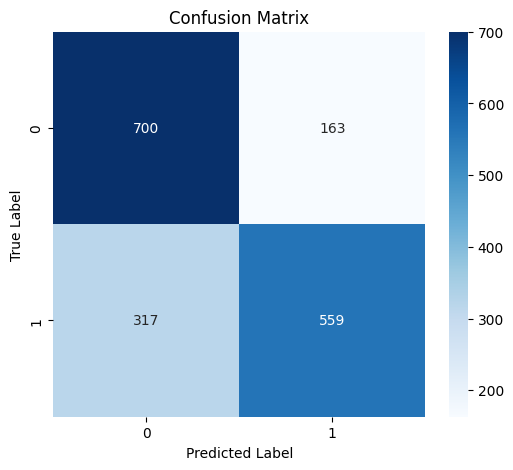

In [371]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

md_logReg = LogisticRegression()
md_logReg.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


y_pred_logReg = md_logReg.predict(x_test)
logReg_accuracy = cross_val_score(md_logReg, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_logReg)
labels = ['True Neg','False Pos','False Neg','True Pos']

print('Accuracy: ', logReg_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_logReg))
print('Sensitivity: ', recall_score(y_test, y_pred_logReg))
print('Specificity: ', recall_score(y_test, y_pred_logReg, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_logReg))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# LDA



Accuracy:  0.7239723077942297
Precision:  0.8002980625931445
Sensitivity:  0.613013698630137
Specificity:  0.8447276940903824
F1-Score:  0.6942469295410472
Matriz de confusion: 



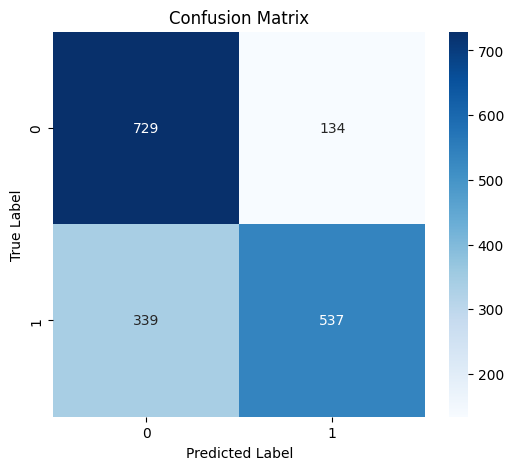

In [372]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

md_lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
md_lda.fit(x_train, y_train)
y_pred_lda = md_lda.predict(x_test)
lda_accuracy = cross_val_score(md_lda, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_lda)
labels = ['True Neg','False Pos','False Neg','True Pos']

print('Accuracy: ', lda_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_lda))
print('Sensitivity: ', recall_score(y_test, y_pred_lda))
print('Specificity: ', recall_score(y_test, y_pred_lda, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_lda))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Árbol de Decisión

Accuracy:  0.6751068269899634
Precision:  0.6929223744292238
Sensitivity:  0.6929223744292238
Specificity:  0.6882966396292005
F1-Score:  0.6929223744292238
Matriz de confusion: 



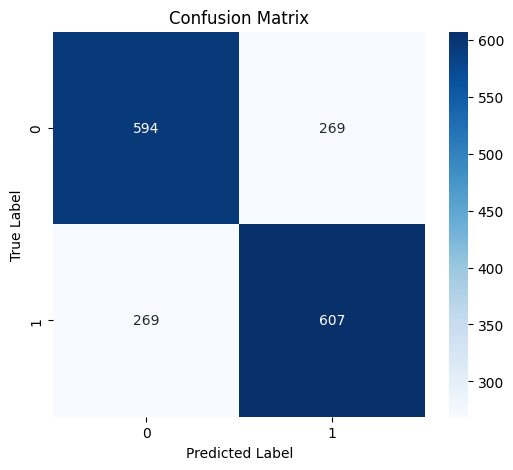

In [373]:
from sklearn.tree import DecisionTreeClassifier

md_tree = DecisionTreeClassifier()
md_tree.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_tree = md_tree.predict(x_test)
tree_accuracy = cross_val_score(md_tree, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_tree)

print('Accuracy: ', tree_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_tree))
print('Sensitivity: ', recall_score(y_test, y_pred_tree))
print('Specificity: ', recall_score(y_test, y_pred_tree, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_tree))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Random Forest


Es importante remarcar que en este modelo se modifico el umbral para generar un mejor resultado. El metodo para determinar el mejor valor fue por prueba y error.

Accuracy:  0.7331875848819106
Precision:  0.750285062713797
Sensitivity:  0.7511415525114156
Specificity:  0.746234067207416
F1-Score:  0.7507130633200229
Matriz de confusion: 



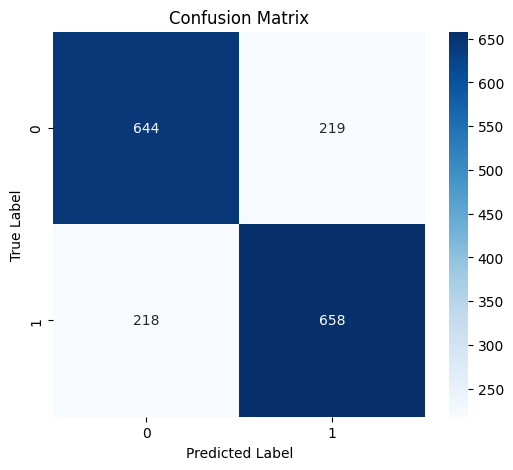

In [374]:
from sklearn.ensemble import RandomForestClassifier as RFC

md_rf = RFC(n_estimators=250, min_samples_split=6, max_depth=15 ,random_state=42)
md_rf.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_rf = md_rf.predict(x_test)

y_probs = md_rf.predict_proba(x_test)[:, 1]
new_threshold = 0.4
y_pred_rf = (y_probs >= new_threshold).astype(int)

rf_accuracy = cross_val_score(md_rf, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_rf)


print('Accuracy: ', rf_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_rf))
print('Sensitivity: ', recall_score(y_test, y_pred_rf))
print('Specificity: ', recall_score(y_test, y_pred_rf, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_rf))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Boosting

Es importante remarcar que en este modelo modifique el umbral para generar un mejor resultado. El metodo para determinar el mejor valor fue prueba y error.

Accuracy:  0.7308738282155751
Precision:  0.7189901207464325
Sensitivity:  0.747716894977169
Specificity:  0.7033603707995365
F1-Score:  0.7330721880246223
Matriz de confusion: 



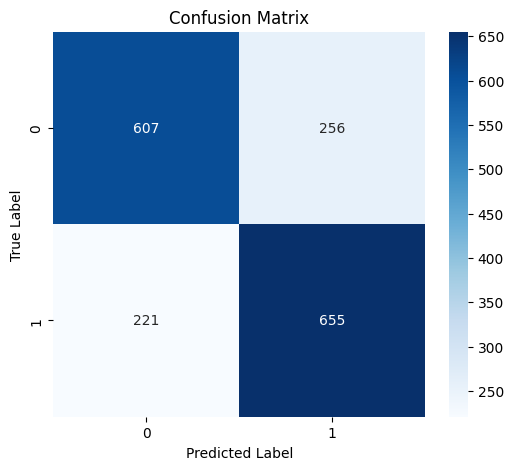

In [375]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

md_boost = AdaBoostClassifier( n_estimators=100, random_state=42)
md_boost.fit(x_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_boost = md_boost.predict(x_test)


y_probs = md_boost.predict_proba(x_test)[:, 1]
new_threshold = 0.45
y_pred_boost = (y_probs >= new_threshold).astype(int)

boost_accuracy = cross_val_score(md_boost, x_test, y_test, cv=kf, scoring='accuracy')
cm = confusion_matrix(y_test, y_pred_boost)
print('Accuracy: ', boost_accuracy.mean())
print('Precision: ', precision_score(y_test, y_pred_boost))
print('Sensitivity: ', recall_score(y_test, y_pred_boost))
print('Specificity: ', recall_score(y_test, y_pred_boost, pos_label=0))
print('F1-Score: ', f1_score(y_test, y_pred_boost))
print('Matriz de confusion: \n')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Comparacion de modelos


In [376]:
md = ['Regresion Logistica', 'LDA', 'Arbol de Decision', 'Random Forest', 'Boosting']
acc = [logReg_accuracy.mean(), lda_accuracy.mean(), tree_accuracy.mean(), rf_accuracy.mean(), boost_accuracy.mean()]
prec = [precision_score(y_test, y_pred_logReg), precision_score(y_test, y_pred_lda), precision_score(y_test, y_pred_tree), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_boost)]
sens = [recall_score(y_test, y_pred_logReg), recall_score(y_test, y_pred_lda), recall_score(y_test, y_pred_tree), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_boost)]
spec = [recall_score(y_test, y_pred_logReg, pos_label=0), recall_score(y_test, y_pred_lda, pos_label=0), recall_score(y_test, y_pred_tree, pos_label=0), recall_score(y_test, y_pred_rf, pos_label=0), recall_score(y_test, y_pred_boost, pos_label=0)]
f1_score_1 = [f1_score(y_test, y_pred_logReg), f1_score(y_test, y_pred_lda), f1_score(y_test, y_pred_tree), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_boost)]

comp_df = pd.DataFrame({'Modelo': md, 'Accuracy': acc, 'Precision': prec, 'Sensibilidad': sens, 'Especificidad': spec, 'F1-Score': f1_score_1})
comp_df = comp_df.set_index('Modelo')

comp_df

,Accuracy,Precision,Sensibilidad,Especificidad,F1-Score
Modelo,,,,,
Regresion Logistica,0.717652,0.774238,0.638128,0.811124,0.699625
LDA,0.723972,0.800298,0.613014,0.844728,0.694247
Arbol de Decision,0.675107,0.692922,0.692922,0.688297,0.692922
Random Forest,0.733188,0.750285,0.751142,0.746234,0.750713
Boosting,0.730874,0.718990,0.747717,0.703360,0.733072


Se puede observar que el modelo con mejor f1_score es el Random Forest, esto quiere decir que tiene un mejor promedio de proporciones entre sensibilidad y especificidad, este modelo cuenta con un accuracy de 0.73, que tambien es el mas alto de todos los modelos. El valor mas bajo de f1_score fue el de Árbol de Decision, con un valor de 0.68 y un accuracy de 0.67.

En las matrices de confusion se observan predicciones balanceadas, y un numero de errores en las predicciones similar para boosting, random forest, y arboles de decision. Para los modelos generados con LDA y Regresion logistica, se observan matrices con numero similar de predicciones correctas.

El modelo que se utilizara para generar el archivo csv para la competencia de kaggle, sera Random Forest y se tomara en cuenta la modificacion del umbral. Ya que el modelo de boosting quedo en segundo lugar, tambien lo utilizare para generar un archivo de respuesta para la competencia, tambien se tomara en cuenta el valor de umbral modificado.

# Prueba Final con modelo de Random Forest

En ambas pruebas a continuacion se utilizara la base de datos de test, que tambien fue previamente procesada.


In [377]:
df_test_processed_wo = df_test_processed.drop(['PassengerId'], axis = 1)

norm = StandardScaler()
df_test_processed_wo = norm.fit_transform(df_test_processed_wo)
y_pred_test = md_rf.predict(df_test_processed_wo)

y_probs = md_rf.predict_proba(df_test_processed_wo)[:, 1]
new_threshold = 0.4
y_pred_test = (y_probs >= new_threshold).astype(bool)

y_pred_test = y_pred_test.astype(bool)
results = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': y_pred_test})
results.to_csv('results.csv', index=False)

In [378]:
print('Numero de resultados True: ', results['Transported'].value_counts()[True])
print('Numero de resultados False: ', results['Transported'].value_counts()[False])

Numero de resultados True:  1985
Numero de resultados False:  2292


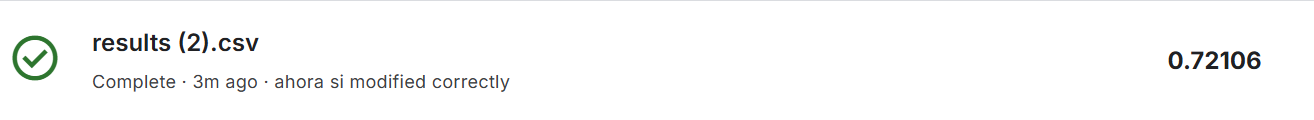

Despues de mandar el archivo de resultados de este modelo presento un valor de 0.72, que se considera un buen resultado, sin embargo hay mucho rango de mejora.

# Prueba final con modelo utilizando Boosting

In [379]:
norm = StandardScaler()
df_test_processed_wo = norm.fit_transform(df_test_processed_wo)

y_pred_test_2 = md_boost.predict(df_test_processed_wo)

y_probs_2 = md_boost.predict_proba(df_test_processed_wo)[:, 1]
new_threshold = 0.45
y_pred_test_2 = (y_probs_2 >= new_threshold).astype(int)


y_pred_test_2 = y_pred_test_2.astype(bool)
results = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': y_pred_test_2})
results.to_csv('results_boost.csv', index=False)

In [380]:
print('Numero de resultados True: ', results['Transported'].value_counts()[True])
print('Numero de resultados False: ', results['Transported'].value_counts()[False])

Numero de resultados True:  1342
Numero de resultados False:  2935


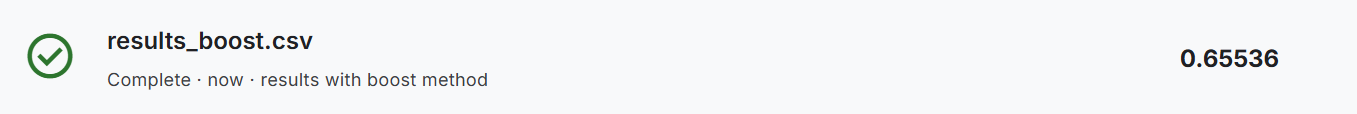

Al mandar los resultados a la competencia nos regreso un valor de 0.655, que se considera un valor con muchas areas de oportunidad.

El modelo ganador fue el generado con Random Forest, ya que genero un mejor resultado.